# Density Estimation with Haar Wavelets

We fit 1D data sampled from a distribution with Haar wavelets, a complete basis of functions made up of "small-scale" and "large-scale" pieces. We do this via maximum likelihood estimation. Naively, we might take the PDF to be a dyadic wavelet expansion
$$ p(x) = \sum_{k} \alpha_{j_0 , k} \phi_{j_0 , k}(x) + \sum_{j \geq j_0 , k} \beta_{j , k} \psi_{j , k}(x), \$$
where $\phi$ is the scaling function (father wavelet) and $\psi$ is the wavelet function (mother wavelet). However, as we would truncate this sum at some maximal scale, the approximation is not guaranteed to be non-negative. To ensure this, we can instead use the wavelets to describe $\sqrt{p(x)}$
$$ \sqrt{p(x)} = \sum_{k} \alpha_{j_0 , k} \phi_{j_0 , k}(x) + \sum_{j \geq j_0 , k} \beta_{j , k} \psi_{j , k}(x). $$

This technique was first proposed in https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2921978/.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform
from scipy.integrate import quad

import sys, os, time, fileinput

import matplotlib.pyplot as plt
import matplotlib as mpl

plt.style.use('default') 

## Toy Data

Distribution consists of several randomly placed point sources, a Gaussian, and a uniform background.

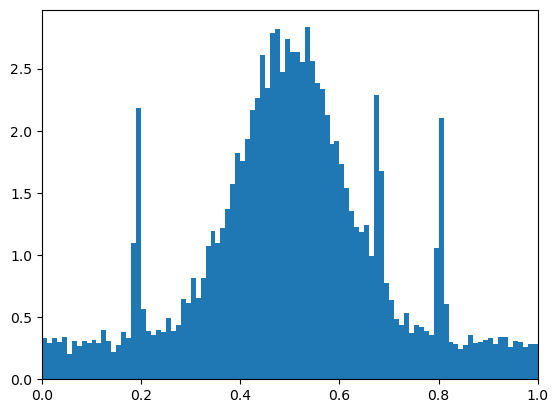

In [14]:
# sample data from normal distribution 
N_data = 10000

# preload sample data
x_data = np.array([])

# point source samples
Ng = 5
N_scales = uniform.rvs(size = Ng)
scales = 0.005 * uniform.rvs(size = Ng)
scales = 0.005 * np.ones(Ng)
locs = 0.8 * uniform.rvs(size = Ng) + 0.1
for n in range(Ng):
    nm_small = norm(scale = scales[n], loc = locs[n])
    x_data_small = nm_small.rvs(size = int(N_scales[n] * N_data / 20))
    x_data = np.concatenate((x_data, x_data_small))
    
# gaussian samples
nm_large = norm(scale = 0.1, loc = 0.5)
x_data_large = nm_large.rvs(size = N_data)
x_data = np.concatenate((x_data, x_data_large))

# uniform samples
uni = uniform
x_data_uni = uni.rvs(size = int(N_data / 2))
x_data = np.concatenate((x_data, x_data_uni))

# plot histogram of distribution
counts, bins, _ = plt.hist(x_data, bins = 100, density = True)
plt.xlim([0,1])

N = len(x_data)

In [15]:
# load pywt haar wavelets for comparison

import pywt
wavelet_name = 'haar'

wavelet = pywt.Wavelet(wavelet_name)
phi, psi, x = wavelet.wavefun(level=9) # level does not affect timing
L = int(x[-1] - x[0])

(-0.25, 1.25)

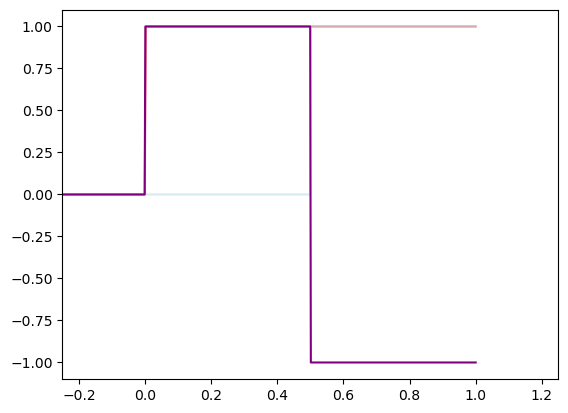

In [16]:
# rescale to unit length
x = x/L
phi = np.sqrt(L) * phi
psi = np.sqrt(L) * psi

# define standard haar wavelet and scaling function
def haar_mother_(t): 
    return (np.heaviside(t,0) - np.heaviside(t-1,0) ) * np.interp(t,x,psi)

def haar_scale_(t):
    return (np.heaviside(t,0) - np.heaviside(t-1,0) ) * np.interp(t,x,phi)

x_p = np.linspace(-1,1,1000)
plt.plot(x_p, haar_scale_(x_p - 0), c = 'red', alpha = 0.5)
plt.plot(x_p, haar_scale_(2 * x_p - 1), c = 'lightblue', alpha = 0.5)
plt.plot(x_p, haar_scale_(2 * x_p - 0) - haar_scale_(2 * x_p - 1), c = 'purple')

plt.xlim([-0.25,1.25])

In [17]:
# define dyadic version of wavelet and scaling function
def psi_(x,j,k):
    return 2**(j/2) * haar_mother_(2**j * x  - k)

def phi_(x,j0,k):
    return 2**(j0/2) * haar_scale_(2**j0 * x  - k)

## MLE
For our fit, we choose
$$ \sqrt{p(x)} = \sum_{k} \alpha_{j_1 , k} \phi_{j_1 , k}(x), $$
where $j_1$ now defines the smallest scale of the Haar wavelet. Nevertheless, the more general expression above holds. So, we can obtain our best-fit and decompose it using a larger scaling function and wavelets to distinguish large and small-scale features.

Moreover, our MLE is actually a constrained optimization problems. Since, we enforce 
$$ \int dx \ p(x) = 1, $$
which, by virtue of the fact that each scaling function in the sum has unit norm and shares no support with another, becomes
$$ \sum_{k} |\alpha_{j_0 , k}|^{2} = 1. $$

We enforce this constraint by converting the $\alpha$-values to coordinates in the unit hypersphere.

In [18]:
j1 = 7 # maximum scale (6 -> ~2 min , 7 -> ~9 min)
klist1 = np.arange(0,2**j1 - 1 + 0.5,1) # translations
Nk1 = np.size(klist1)

scale_info = [j1, klist1]

In [20]:
# plot the density estimate using scaling coefficients

def angles_for_equal_components_(N):
    """ Generate the angles in spherical coordinates corresponding to a 
    vector whose components are all equal """
    # N = Number of angles required to specify sphere
    arg_for_sqrt = np.arange(N+1, 3-0.5, -1)
    polar_list = np.arccos( 1 /
                           np.sqrt(arg_for_sqrt)
                          )
    azi_list = np.array([np.pi/4])
    return np.concatenate((polar_list, azi_list))

def initial_scaling_angle_generator_(N, choice):
    """Generates a set of initial scaling angles on the sphere
    N = Dimension of Euclidean Space
    choice = Determine type of scaling angles to generate
    'random': Generate a random sample of angles on the sphere
    'unbiased': All scaling coefficients have the same positive value
    'equiangle': All angles correspond to pi/4"""
    if choice == 'random':
        return np.concatenate((np.pi * np.random.random(size = N - 2), 2*np.pi*np.random.random(size = 1) ))
    elif choice == 'unbiased':
        return angles_for_equal_components_(N-1)
    elif choice == 'equiangle':
        return np.concatenate((np.pi/4 * np.random.random(size = N - 2), np.pi/4*np.ones(1) ))
    
def ct(r, arr):
    """
    coordinate transformation from spherical to cartesian coordinates
    """
    a = np.concatenate((np.array([2*np.pi]), arr))
    si = np.sin(a)
    si[0] = 1
    si = np.cumprod(si)
    co = np.cos(a)
    co = np.roll(co, -1)
    return si*co*r

def scaling_coefficients_(scaling_angles):
    """
    convert scaling angles in hypersphere to scaling coefficients
    """
    return ct(1,scaling_angles)

def sqrt_p_(x_data, scaling_angles):
    """
    Calculate the square root of the density estimate as the wavelet expansion
    with the scaling coefficients denoted by the scaling angles
    """
    N = len(x_data)
    j1, klist1 = scale_info
    phi_arr = np.array([phi_(x_data,j1,klist1[nk]) for nk in range(Nk1)])
    scaling_coefficients = scaling_coefficients_(scaling_angles)
    scaling_coefficients_mat = np.outer(scaling_coefficients, np.ones((N,)))
    scale_terms = scaling_coefficients_mat * phi_arr
    return np.sum(scale_terms, axis = 0)

def safe_log_(x):
    # guard against x = 0
    return np.log(x + 1e-323)

def unbinned_nll_(x):
    return -np.sum(safe_log_(x))

def unbinned_nll_sqrt_p_(scaling_angles):
    sqrt_p_arr = sqrt_p_(x_data, scaling_angles)
    p_arr = sqrt_p_arr * sqrt_p_arr
    return unbinned_nll_(p_arr) / N

In [21]:
from iminuit import cost, Minuit

# unbiased initial scaling angles
initial_scaling_angles = initial_scaling_angle_generator_(Nk1, 'unbiased')
# initial_scaling_angles = initial_scaling_angle_generator_(Nk1, 'random')

# define iminuit object for minimization
m = Minuit(unbinned_nll_sqrt_p_, initial_scaling_angles)

# limited to sphere
limits_theta = [(0,np.pi) for n in range(Nk1-2)]
limits_phi = [(0,2*np.pi)]
limits = np.concatenate((limits_theta, limits_phi))

# set limits
m.limits = limits

# run fit
m.errordef = Minuit.LIKELIHOOD
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -0.3265                    │             Nfcn = 10376             │
│ EDM = 8.51e-09 (Goal: 0.0001)    │           time = 544.2 sec           │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌────┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│    │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├────┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0  │ x0   │    1.5    │    0.5    │            │            │    0    │ 3.14159 │       │
│ 1  │ x1   │    1.5    │    0.5    │            │            │    0    │ 3.14159 │       │
│ 2  │ x2   │    1.5    │    0.5    │            │            │    0    │ 3.14159 │       │
│ 3  │ x3   │    1.5    │    0.5    │            │            │    0    │ 3.14159 │       │
│ 4  │ x4   │    1.5    │    0.5    │            │            │    0    │ 3.14159 │       │
│ 5  │ x5   │    1.5    │    0.5    │            │            │    0    │ 3.14159 │       │
│ 6  │ x6   │    1.5    │    0.5    │            │            │    0    │ 3.14159 │       │
│ 7  │ x7   │    1.5    │    0.5    │            │            │    0    │ 3.14159 │       │
│ 8  │ x8   │    1.5    │    0.5    │            │            │    0    │ 3.14159 │       │
│ 9  │ x9   │    1.5    │    0.5    │            │            │    0    │ 3.14159 │       │
│ 10 │ x10  │    1.5    │    0.5    │            │            │    0    │ 3.14159 │       │
│ 11 │ x11  │    1.5    │    0.5    │            │            │    0    │ 3.14159 │       │
│ 12 │ x12  │    1.5    │    0.5    │            │            │    0    │ 3.14159 │       │
│ 13 │ x13  │    1.5    │    0.5    │            │            │    0    │ 3.14159 │       │
│ 14 │ x14  │    1.5    │    0.5    │            │            │    0    │ 3.14159 │       │
│ 15 │ x15  │    1.5    │    0.5    │            │            │    0    │ 3.14159 │       │
│ 16 │ x16  │    1.5    │    0.5    │            │            │    0    │ 3.14159 │       │
│ 17 │ x17  │    1.5    │    0.5    │            │            │    0    │ 3.14159 │       │
│ 18 │ x18  │    1.5    │    0.5    │            │            │    0    │ 3.14159 │       │
│ 19 │ x19  │    1.5    │    0.5    │            │            │    0    │ 3.14159 │       │
│ 20 │ x20  │    1.5    │    0.5    │            │            │    0    │ 3.14159 │       │
│ 21 │ x21  │    1.5    │    0.5    │            │            │    0    │ 3.14159 │       │
│ 22 │ x22  │    1.5    │    0.5    │            │            │    0    │ 3.14159 │       │
│ 23 │ x23  │    1.5    │    0.5    │            │            │    0    │ 3.14159 │       │
│ 24 │ x24  │    1.4    │    0.5    │            │            │    0    │ 3.14159 │       │
│ 25 │ x25  │    1.5    │    0.5    │            │            │    0    │ 3.14159 │       │
│ 26 │ x26  │    1.5    │    0.5    │            │            │    0    │ 3.14159 │       │
│ 27 │ x27  │    1.5    │    0.5    │            │            │    0    │ 3.14159 │       │
│ 28 │ x28  │    1.5    │    0.5    │            │            │    0    │ 3.14159 │       │
│ 29 │ x29  │    1.5    │    0.5    │            │            │    0    │ 3.14159 │       │
│ 30 │ x30  │    1.5    │    0.5    │            │  

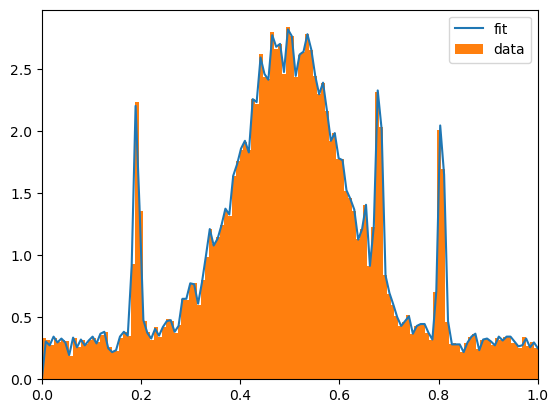

In [22]:
# plot the fit
x_plot = np.linspace(0,1,128)
scaling_angles_fit = m.values[:]
sqrt_p_plot = sqrt_p_(x_plot, scaling_angles_fit)
p_plot = sqrt_p_plot * sqrt_p_plot

plt.plot(x_plot, p_plot, label = 'fit')
counts, bins, _ = plt.hist(x_data, bins = 128, density = True, label = 'data')

plt.xlim([0,1])
plt.legend()

## Wavelet Decomposition

Once we have the fit, we can redefine the basis using a wavelet decomposition. We do this with the objective of separating out the point sources from the background. 

Below, we decompose to the representation $j_0 = j_1 - 4$. That is,
$$ \sqrt{p(x)} = \sum_{k} \alpha_{j_0 , k} \phi_{j_0 , k}(x) + \sum_{j \geq j_0 , k}^{j_1} \beta_{j , k} \psi_{j , k}(x). $$

We refer to the previous representation as the "Fine" representation. The sum of the scaling functions given here are referred to as the "Coarse" representation.

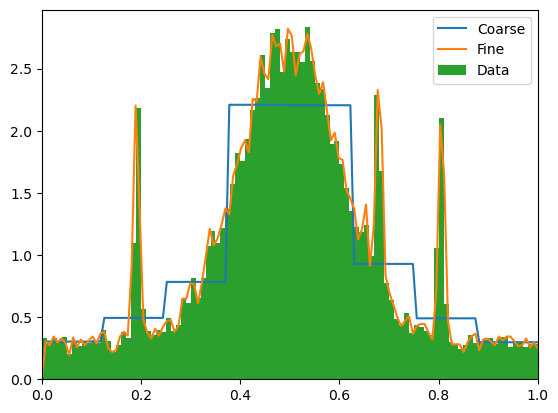

In [24]:
sqrt_p_plot_j1 = sqrt_p_plot

j0 = j1 - 4
level = j1 - j0
scaling_coefficients_fit = np.abs(scaling_coefficients_(scaling_angles_fit))
coeffs = pywt.wavedec(scaling_coefficients_fit, wavelet_name, level=level)
scaling_coefficients_j0 = coeffs[0]
wavelet_coefficients_j0 = coeffs[1:]

klist0 = np.arange(0,2**j0 - 1 + 0.5,1)
Nk0 = np.size(klist0)

scale_info = [j0, klist0]

def sqrt_p_coarse_(x_data, scaling_coefficients_j0):
    '''
    Coarse representation of the density estimate
    '''
    N = len(x_data)
    j1, klist1 = scale_info
    phi_arr = np.array([phi_(x_data,j0,klist0[nk]) for nk in range(Nk0)])
    scaling_coefficients_mat = np.outer(scaling_coefficients_j0, np.ones((N,)))
    scale_terms = scaling_coefficients_mat * phi_arr
    return np.sum(scale_terms, axis = 0)

x_plot = np.linspace(0,1,128)
sqrt_p_plot_j0 = sqrt_p_coarse_(x_plot, scaling_coefficients_j0)
p_plot_j0 = sqrt_p_plot_j0 * sqrt_p_plot_j0

plt.plot(x_plot, p_plot_j0)
plt.plot(x_plot, p_plot)
counts, bins, _ = plt.hist(x_data, bins = 100, density = True)
plt.xlim([0,1])
plt.legend(["Coarse", "Fine", "Data"])

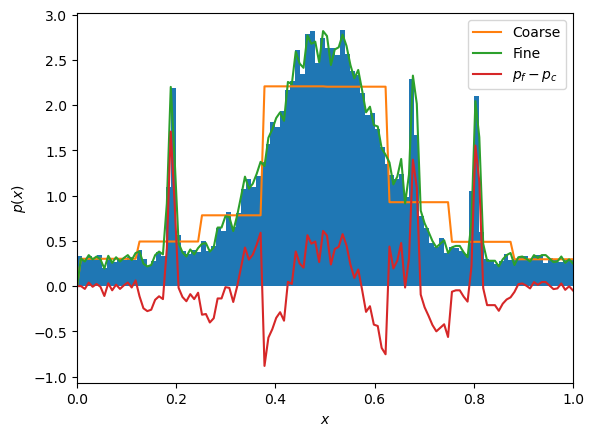

In [25]:
# Fit summary using DWT

counts, bins, _ = plt.hist(x_data, bins = 100, density = True)
plt.plot(x_plot, p_plot_j0, label = 'Coarse')
plt.plot(x_plot, p_plot, label = 'Fine')
plt.plot(x_plot, sqrt_p_plot**2 - sqrt_p_plot_j0**2, label = '$p_f - p_c$')
plt.xlim([0,1])
plt.xlabel('$x$')
plt.ylabel('$p(x)$')
plt.legend()

As can be seen, the point sources are identified with high values in the sum of the wavelet terms. That is, the higher-scale wavelets connecting the coarse and fine representations contain the point sources, as expected.

## Naive Stationary Wavelet Transform Implementation
The stationary wavelet transform is attractive in that it is translation-invariant, unlike the wavelet transform above.

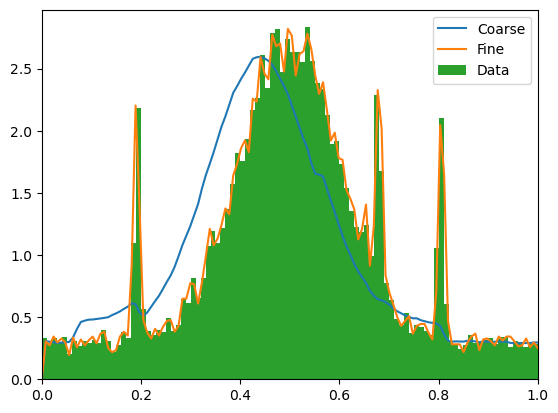

In [33]:
# stationary wavelet transform (test)
# Note: You can't just take the scaling coefficients from the coarse representation; 
## need to take the inverse (see next cell)
# This leads to a shifted signal (idk why)

sqrt_p_plot_j1 = sqrt_p_plot

j0 = j1 - 4
level = j1 - j0
scaling_coefficients_fit = np.abs(scaling_coefficients_(scaling_angles_fit))
coeffs = pywt.swt(scaling_coefficients_fit, wavelet_name, level=level, norm = True, trim_approx = False)
scaling_coefficients_j0 = coeffs[0][0]
wavelet_coefficients_j0 = coeffs[1:]

klist0 = np.arange(0,2**j1 - 1 + 0.5,1)
Nk0 = np.size(klist1)

scale_info = [j1, klist1]

def sqrt_p_coarse_(x_data, scaling_coefficients_j0):
    N = len(x_data)
    j1, klist1 = scale_info
    phi_arr = np.array([phi_(x_data,j1,klist0[nk]) for nk in range(Nk0)])
    scaling_coefficients_mat = np.outer(scaling_coefficients_j0, np.ones((N,)))
    scale_terms = scaling_coefficients_mat * phi_arr
    return np.sum(scale_terms, axis = 0)

x_plot = np.linspace(0,1,128)
sqrt_p_plot_j0 = sqrt_p_coarse_(x_plot, scaling_coefficients_j0)
p_plot_j0 = sqrt_p_plot_j0 * sqrt_p_plot_j0

plt.plot(x_plot, p_plot_j0)
plt.plot(x_plot, p_plot)
counts, bins, _ = plt.hist(x_data, bins = 100, density = True)
plt.xlim([0,1])
plt.legend(["Coarse", "Fine", "Data"])

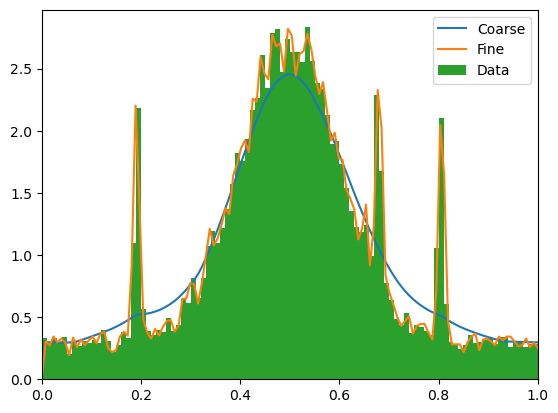

In [36]:
# Reconstruct with inverse wavelet transform
# In this case, we get the desirable effect of removing the signal!
# Similarly, we will be able to extract the signal alone

sqrt_p_plot_j1 = sqrt_p_plot

j0 = j1 - 4
level = j1 - j0
scaling_coefficients_fit = np.abs(scaling_coefficients_(scaling_angles_fit))
coeffs = pywt.swt(scaling_coefficients_fit, wavelet_name, level=level, norm = True)
scaling_coefficients_j0 = coeffs[0][0]

coeffs_th = coeffs

coeffs_th_list_0 = list(coeffs_th[0])
coeffs_th_list_0[1] = np.zeros(np.size(coeffs_th_list_0[1]))
coeffs_th[0] = tuple(coeffs_th_list_0)

coeffs_th_list_1 = list(coeffs_th[1])
coeffs_th_list_1[1] = np.zeros(np.size(coeffs_th_list_1[1]))
coeffs_th[1] = tuple(coeffs_th_list_1)

coeffs_th_list_2 = list(coeffs_th[2])
coeffs_th_list_2[1] = np.zeros(np.size(coeffs_th_list_2[1]))
coeffs_th[2] = tuple(coeffs_th_list_2)

coeffs_th_list_2 = list(coeffs_th[3])
coeffs_th_list_2[1] = np.zeros(np.size(coeffs_th_list_2[1]))
coeffs_th[3] = tuple(coeffs_th_list_2)

coeffs_rec = pywt.iswt(coeffs_th, wavelet_name, norm = True)

scaling_coefficients_rec = coeffs_rec

klist1 = np.arange(0,2**j1 - 1 + 0.5,1)
Nk1 = np.size(klist1)

scale_info = [j1, klist1]

def sqrt_p_coarse_(x_data, scaling_coefficients):
    N = len(x_data)
    j1, klist1 = scale_info
    phi_arr = np.array([phi_(x_data,j1,klist1[nk]) for nk in range(Nk1)])
    scaling_coefficients_mat = np.outer(scaling_coefficients, np.ones((N,)))
    scale_terms = scaling_coefficients_mat * phi_arr
    return np.sum(scale_terms, axis = 0)

x_plot = np.linspace(0,1,128)
sqrt_p_plot_j0 = sqrt_p_coarse_(x_plot, scaling_coefficients_rec)
p_plot_j0 = sqrt_p_plot_j0 * sqrt_p_plot_j0

plt.plot(x_plot, p_plot_j0)
plt.plot(x_plot, p_plot)
counts, bins, _ = plt.hist(x_data, bins = 100, density = True)
plt.xlim([0,1])
plt.legend(["Coarse", "Fine", "Data"])

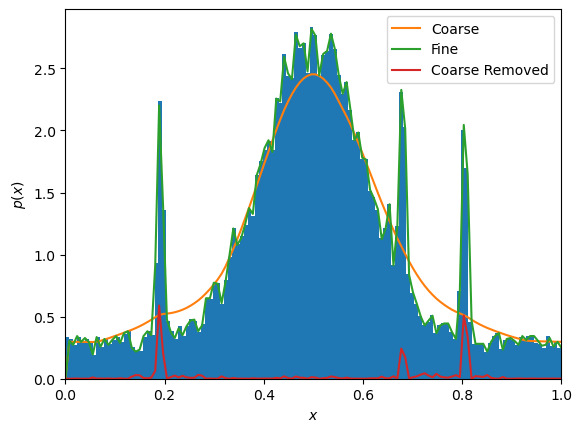

In [37]:
# Fit summary using SWT

counts, bins, _ = plt.hist(x_data, bins = 128, density = True)
plt.plot(x_plot, p_plot_j0, label = 'Coarse')
plt.plot(x_plot, p_plot, label = 'Fine')
plt.plot(x_plot, (np.abs(sqrt_p_plot) - np.abs(sqrt_p_plot_j0))**2, label = 'Coarse Removed')
plt.xlim([0,1])
plt.xlabel('$x$')
plt.ylabel('$p(x)$')
plt.legend()